#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Ресемлирование" data-toc-modified-id="Ресемлирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемлирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-анализу-временного-ряда" data-toc-modified-id="Выводы-по-анализу-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы по анализу временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Деление-данных-на-train-и-test" data-toc-modified-id="Деление-данных-на-train-и-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Деление данных на train и test</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Выводы-по-этапу-обучения" data-toc-modified-id="Выводы-по-этапу-обучения-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выводы по этапу обучения</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span><ul class="toc-item"><li><span><a href="#Предсказание-среднего-значения" data-toc-modified-id="Предсказание-среднего-значения-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Предсказание среднего значения</a></span></li><li><span><a href="#Предсказание-предыдущего-значения" data-toc-modified-id="Предсказание-предыдущего-значения-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Предсказание предыдущего значения</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('./datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [3]:
def basic_data_info(data):
    print('Первые пять строк:')
    display(data.head())
    print('\nИнформация:')
    print(data.info())
    print('\nНаличие пропусков:')
    print(data.isna().sum())
    print('\nСтатистическое описание данных:')
    print(data.describe())

In [4]:
basic_data_info(data)

Первые пять строк:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Информация:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Наличие пропусков:
num_orders    0
dtype: int64

Статистическое описание данных:
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


Мы загрузили данные в датафрейм `data`. Колонка `datetime` исходного файла при загрузке была преобразована в тип `datetime` и установлена как индекс датафрейма. Данные состоят из колонки `num_orders`, в которой хранятся целочисленные значения типа `int64`. В данных нет пропусков.

### Ресемлирование 
Ресемплируем наши данные по одному часу. Возьмем сумму заказов в течение каждого часа.

In [5]:
data = data.resample('1H').sum()

In [6]:
basic_data_info(data)

Первые пять строк:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Информация:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

Наличие пропусков:
num_orders    0
dtype: int64

Статистическое описание данных:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


In [7]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


По условию задачи мы ресемплировали данные по одному часу. Была взята суммарная сумма заказов такси в течение одного часа. Таким образом, в датафрейме `data` представлена информация о суммарных заказах такси в аэропорт каждый час с `2018-03-01 00:00:00` по `2018-08-31 23:00:00`.

## Анализ

In [8]:
data['rolling_mean'] = data['num_orders'].rolling(168).mean()
data['std'] = data['num_orders'].rolling(168).std()

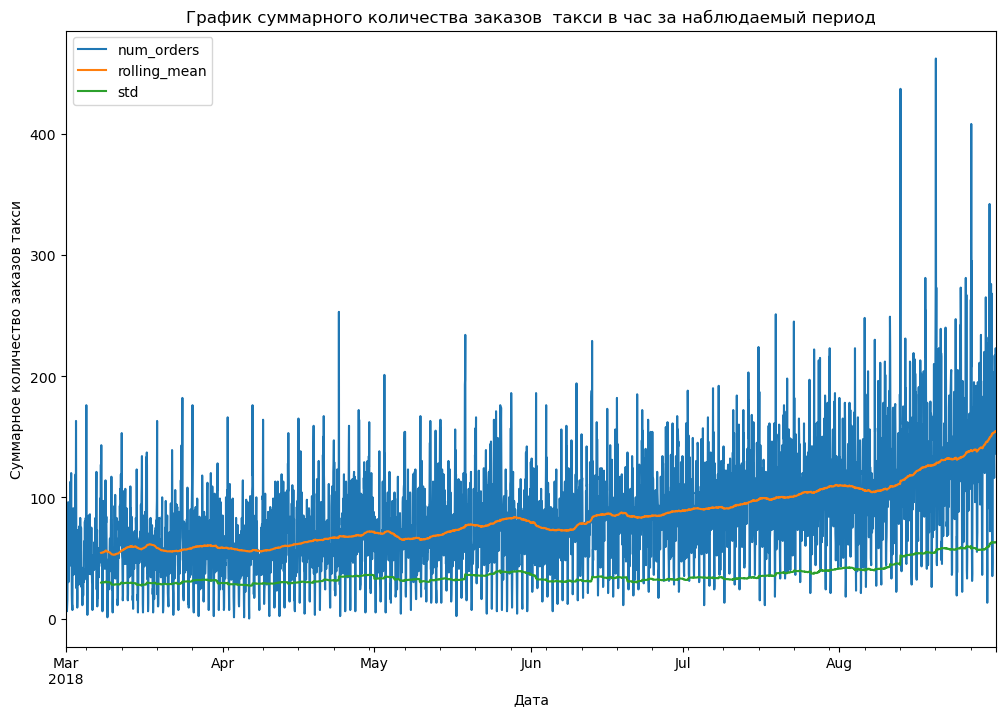

In [9]:
data.plot(figsize=(12,8))
plt.title('График суммарного количества заказов  такси в час за наблюдаемый период')
plt.xlabel('Дата')
plt.ylabel('Суммарное количество заказов такси')
plt.show()

Можем видеть, что временной ряд не является стационарным, потому что у него меняется среднее значение и дисперсия. 

In [10]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("./datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


Можно заметить, что суммарное количество заказов такси в аэропортах увеличивается к летним месяцам. Так как масштаб наших данных ограничен, мы не можем говорить о сезонности, лишь о тренде. Однако, здравый смысл подсказывает, что это сезонная закономерность.

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

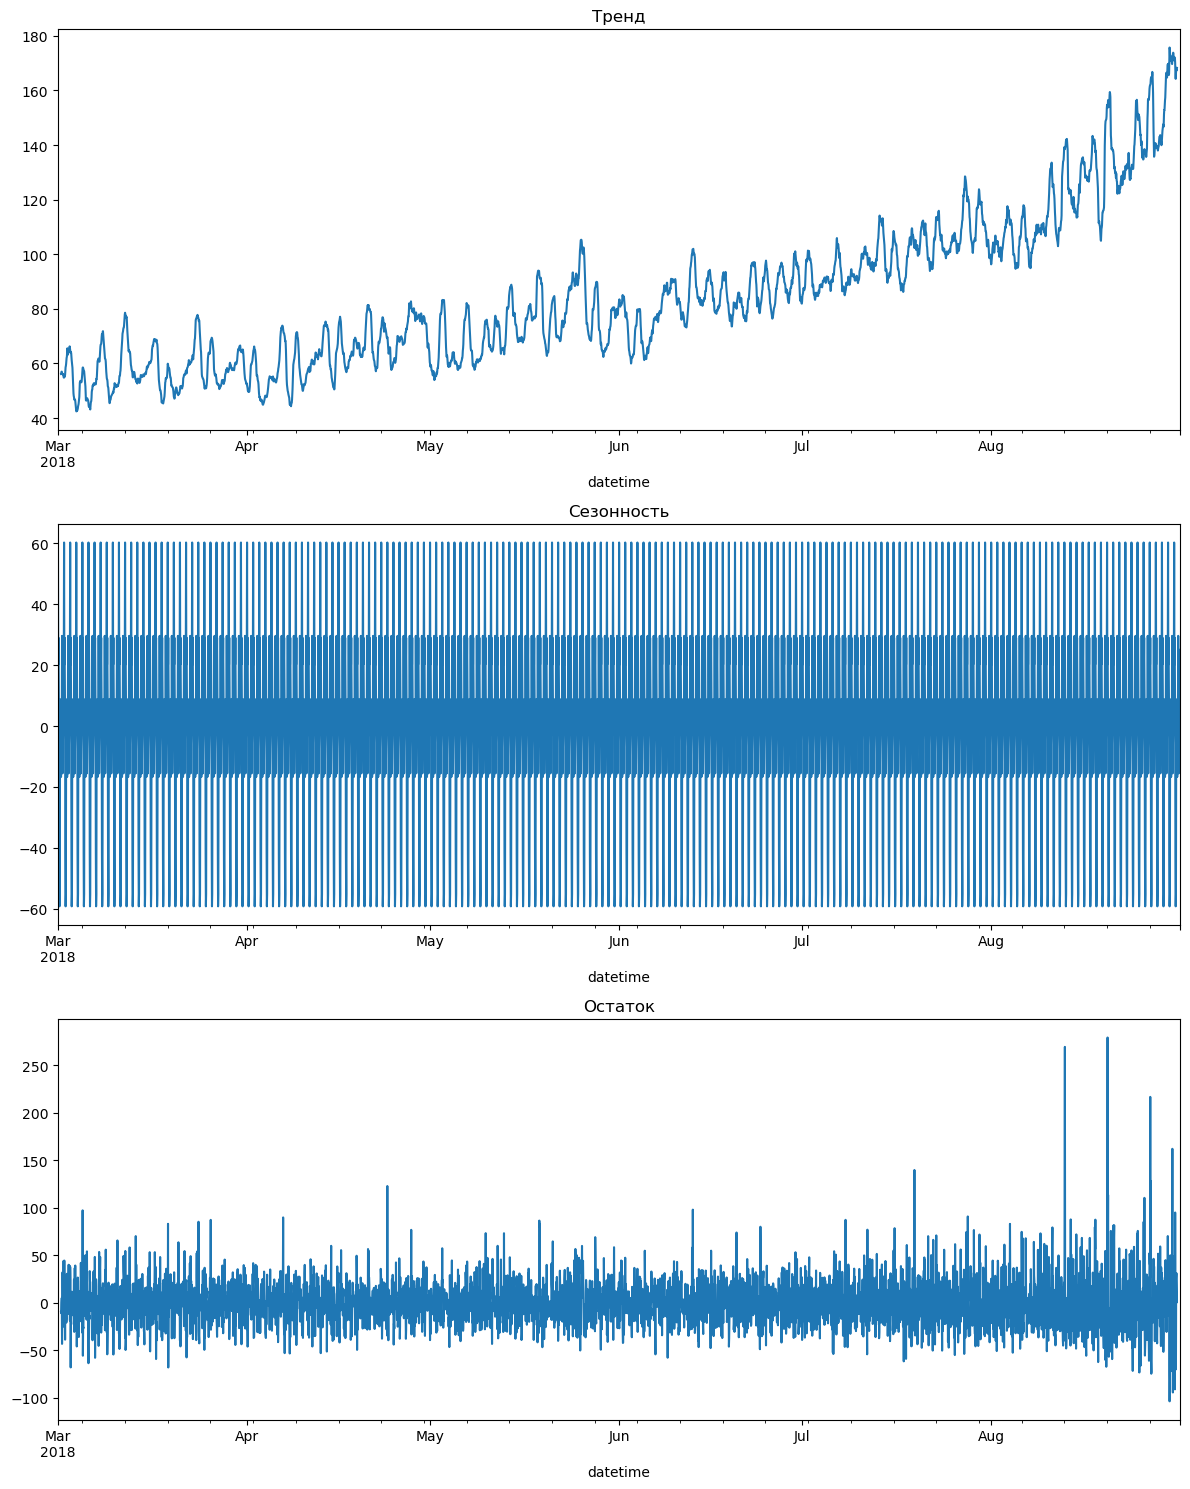

In [12]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

Видим, что доля остатков в конце ряда больше.

In [13]:
data_day = data.resample('1D').sum()

In [14]:
decomposed_day = seasonal_decompose(data_day['num_orders'])

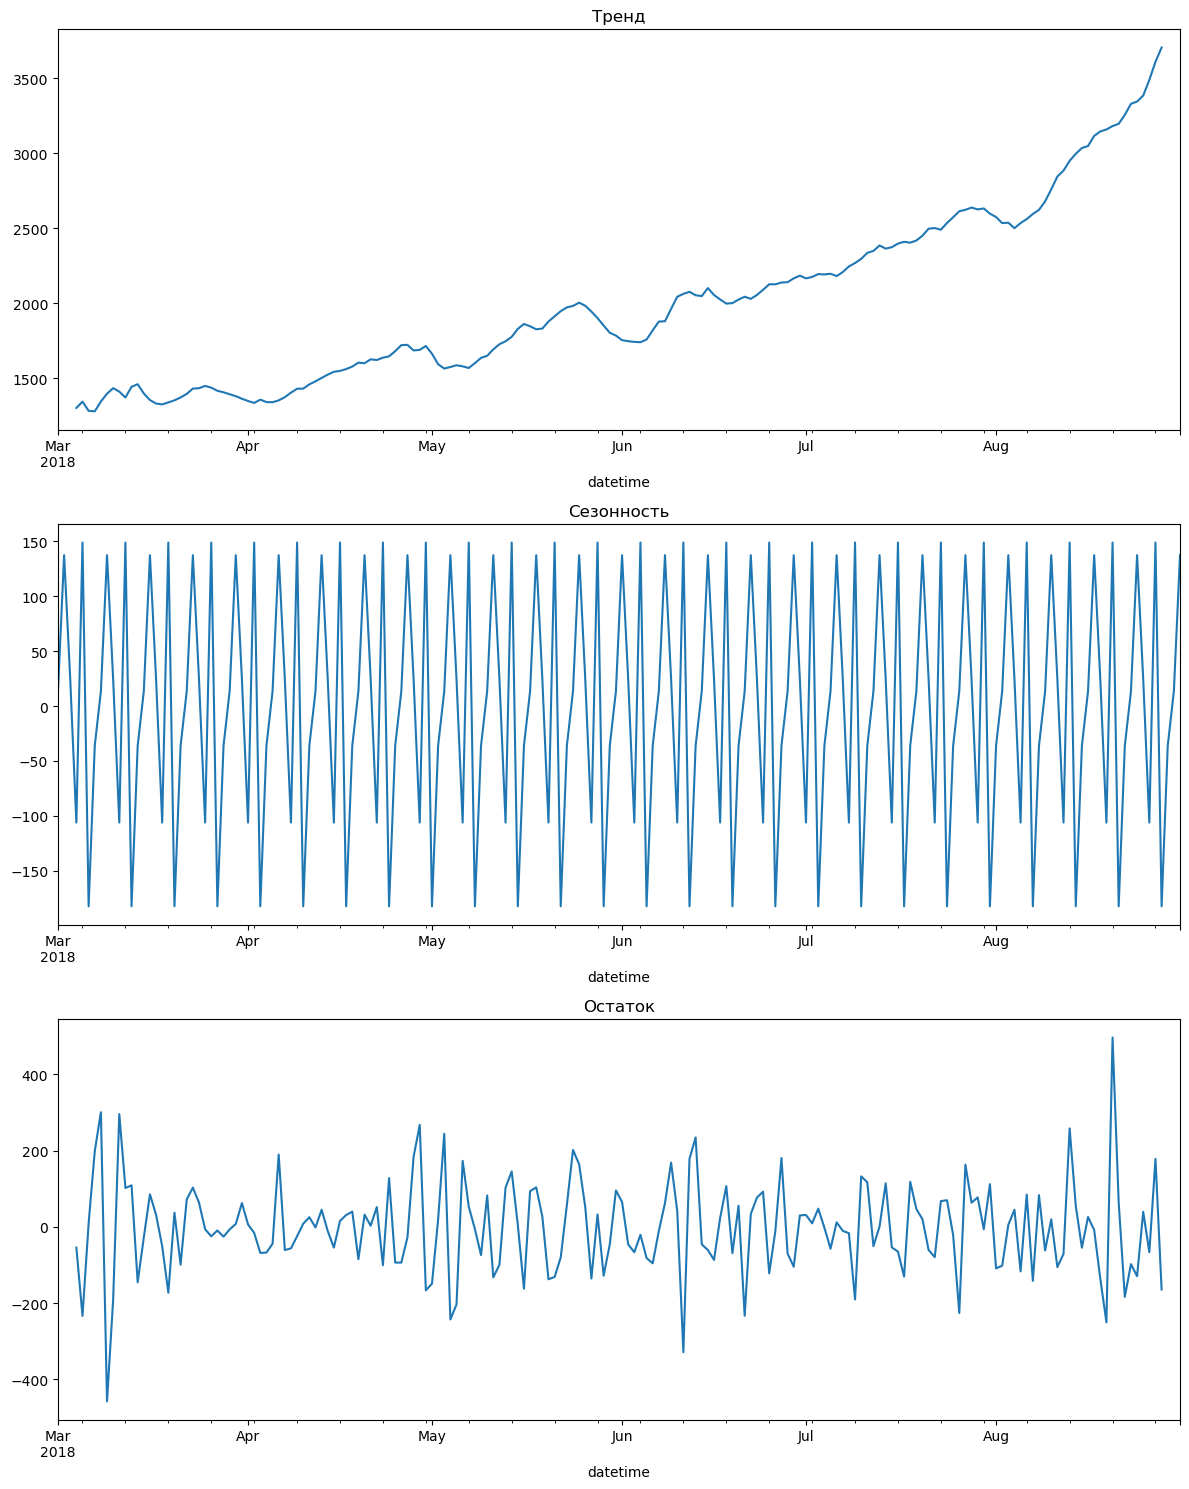

In [15]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

При ресемплировании по дням видно, что есть недельная сезонность.

Изучим более короткий интервал - 1 месяц. Для примера возьмем июнь. Сначала посмотрим на данные, ресемплированные по одному часу.

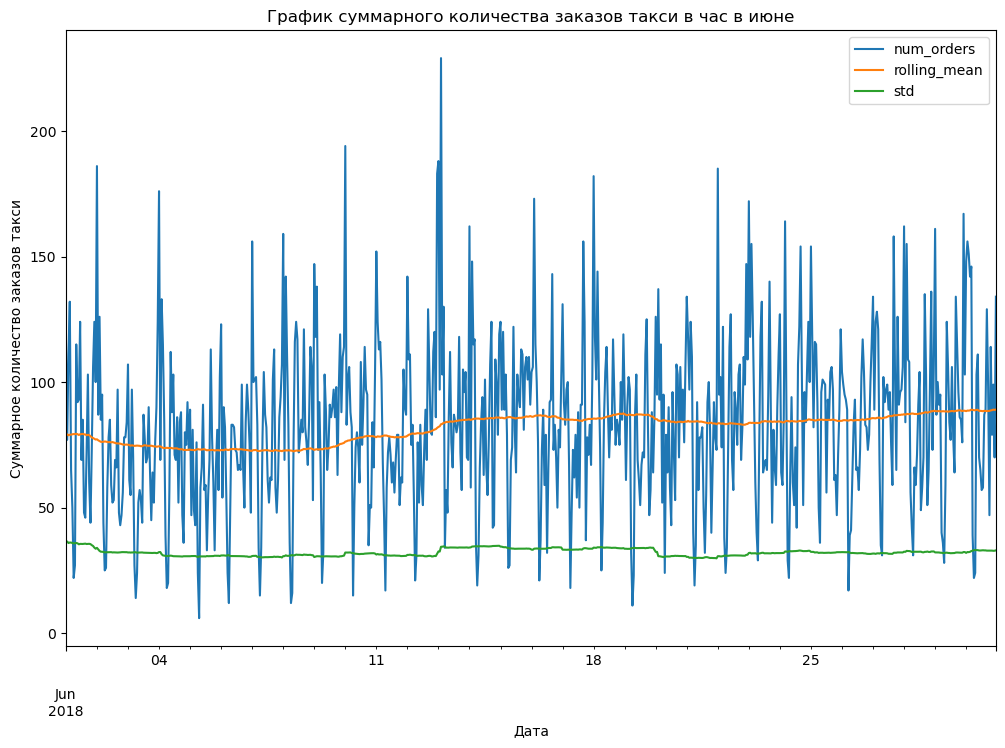

In [16]:
data['2018-06-01':'2018-06-30'].plot(figsize=(12,8))
plt.title('График суммарного количества заказов такси в час в июне')
plt.xlabel('Дата')
plt.ylabel('Суммарное количество заказов такси')
plt.show()

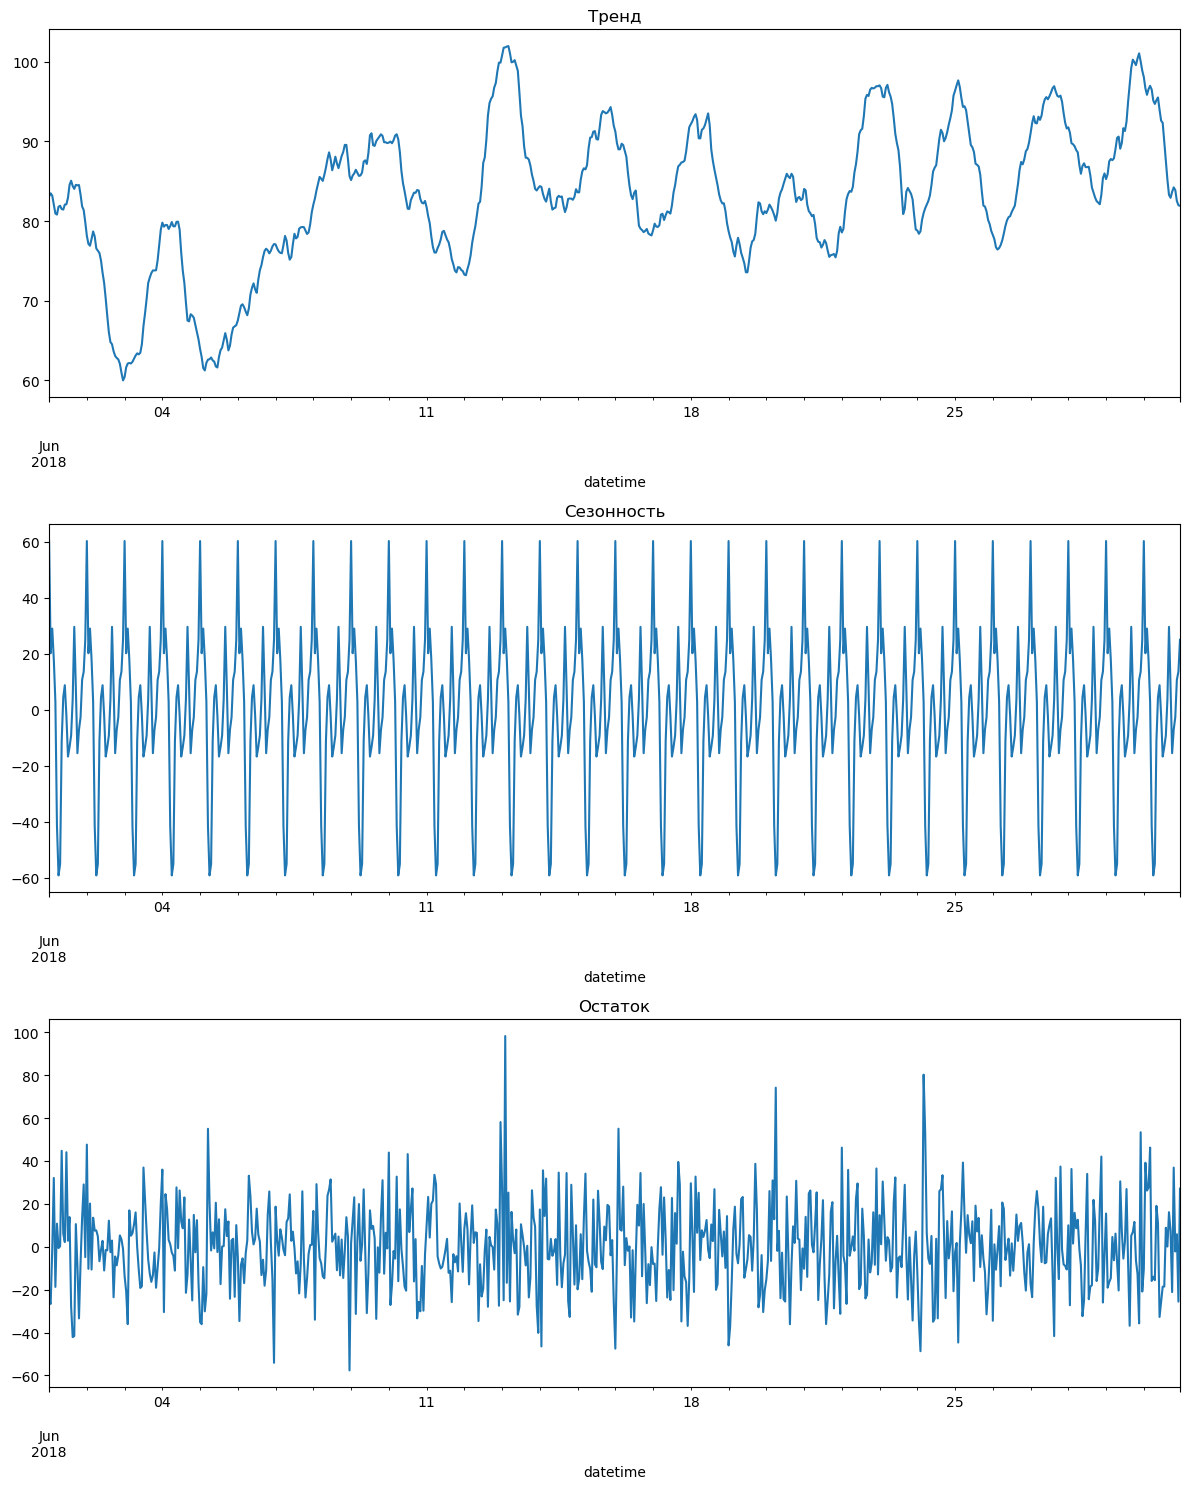

In [17]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-30'].plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-06-01':'2018-06-30'].plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

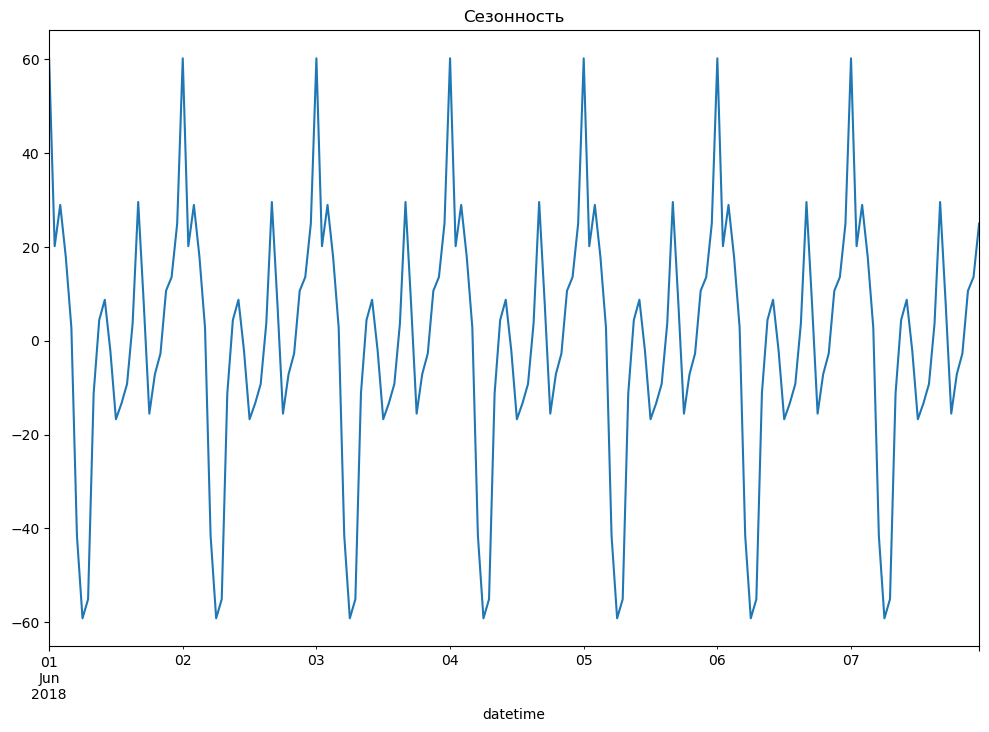

In [18]:
decomposed.seasonal['2018-06-01':'2018-06-07'].plot(figsize=(12, 8)) 
plt.title('Сезонность')
plt.show()

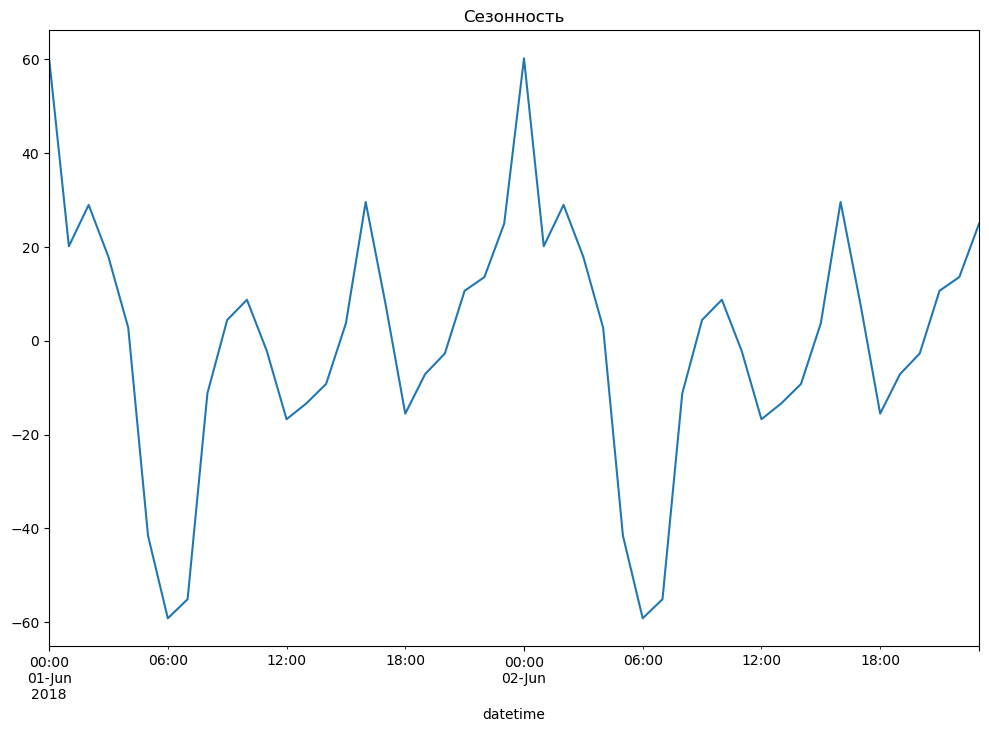

In [19]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(figsize=(12, 8)) 
plt.title('Сезонность')
plt.show()

Мы можем наблюдать сезонность в течение суток: количество вызовов такси падает к шести утра (начинает ходить аэроэкспресс? :)) и возрастает к полуночи.

Теперь снова вернемся к данным, ресемплированным по дням.

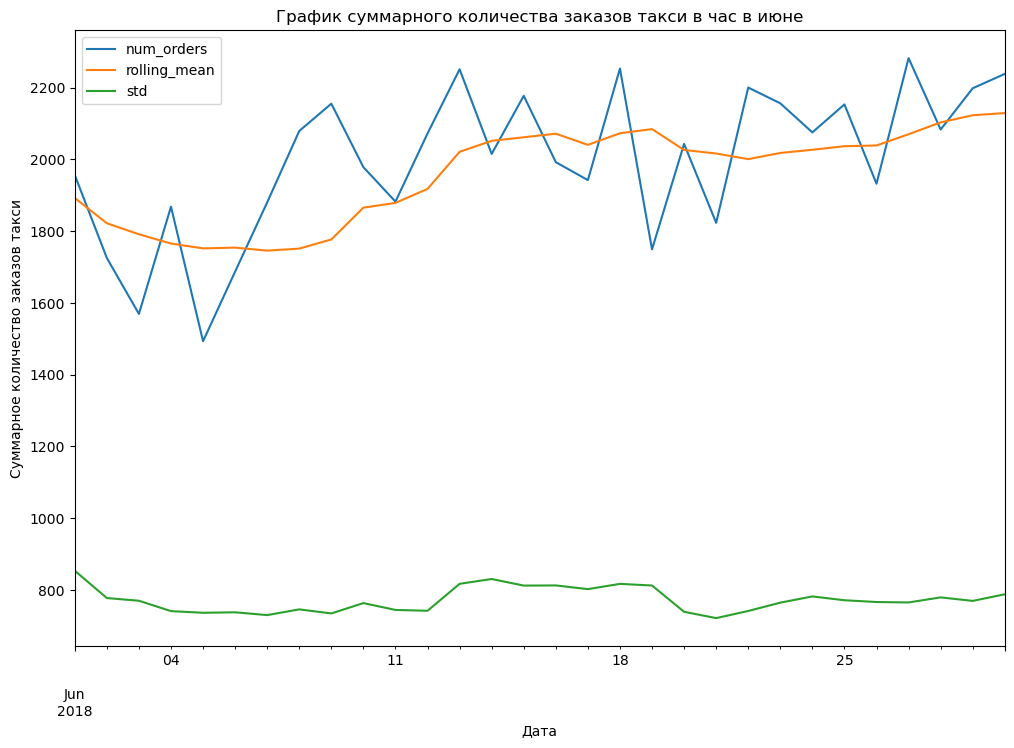

In [20]:
data_day['2018-06-01':'2018-06-30'].plot(figsize=(12,8))
plt.title('График суммарного количества заказов такси в час в июне')
plt.xlabel('Дата')
plt.ylabel('Суммарное количество заказов такси')
plt.show()

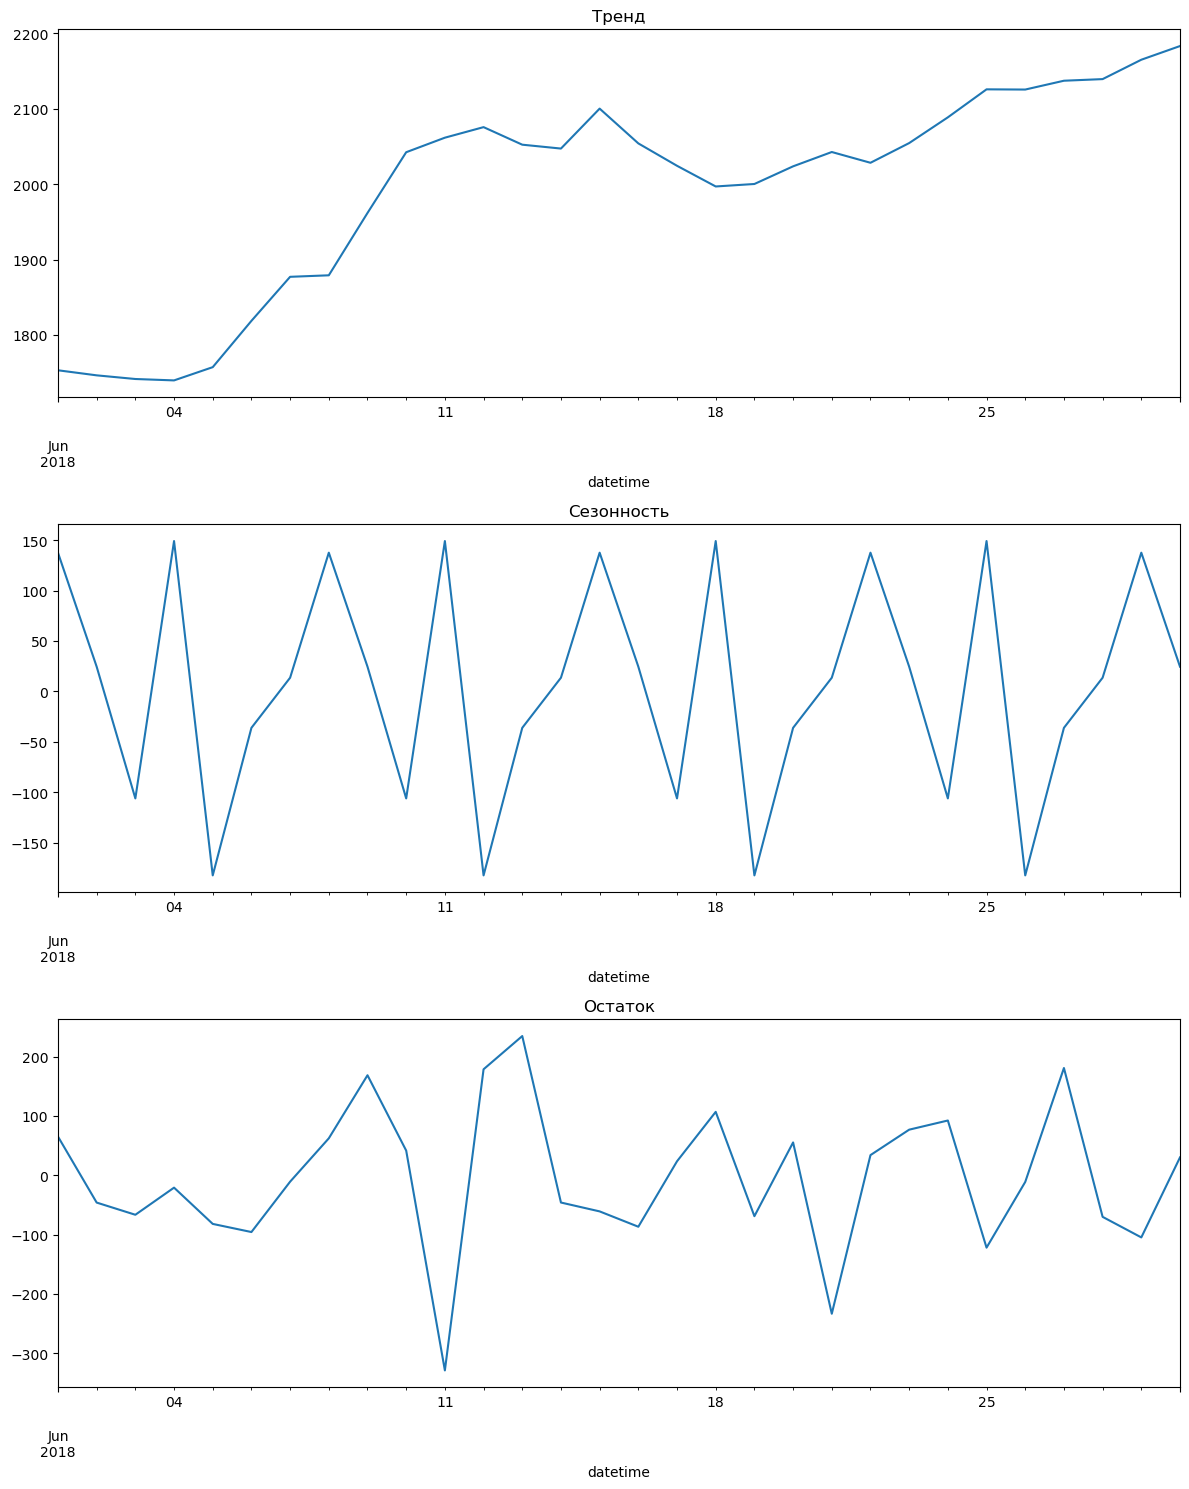

In [21]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed_day.trend['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_day.seasonal['2018-06-01':'2018-06-30'].plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed_day.resid['2018-06-01':'2018-06-30'].plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

Видим на графике недельную сезонность: вызовы такси растут в пятницу и понедельник (видимо, ночь с воскресенья на понедельник). По вторникам люди реже вызывают такси в аэропорт.

### Выводы по анализу временного ряда

Мы провели анализ временного ряда и выяснили следующее:
1. Среднее значение временного ряда растет со временем, т.е. его нельзя назвать стационарным в строгом смысле, но он приводим к станционарному.
2. Наблюдается тренд к увеличению суммарного количества заказов в летние месяцы, особенно - в августе. Масштаб данных не дает сделать выводы о сезонности этого явления.
3. Наблюдается сезонность в рамках одного дня: сумма заказов минимальна в 6 утра и максимальна в полночь.
4. Наблюдается недельная сезонность: количество заказов минимально во вторник и максимально в пятницу и понедельник.
5. К концу графика наблюдается б*о*льшая доля остатков.

## Обучение

### Деление данных на train и test

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data[f'rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [23]:
data = data.drop(['rolling_mean', 'std'], axis=1)

In [24]:
make_features(data, 168, 24)

C:\Users\User\AppData\Local\Temp\ipykernel_18696\2296408487.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{lag}'] = data['num_orders'].shift(lag)
C:\Users\User\AppData\Local\Temp\ipykernel_18696\2296408487.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{lag}'] = data['num_orders'].shift(lag)
C:\Users\User\AppData\Local\Temp\ipykernel_18696\2296408487.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [25]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

In [26]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [27]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [28]:
features_train = features_train.dropna()
target_train = target_train[features_train.index]

In [29]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


### Линейная регрессия
Сначала обучим модель линейной регрессии.

In [30]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression() 
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
rmse_lr = round(np.mean(-score_lr)**0.5, 2)
print(f"RMSE на кросс-валидации по трем фолдам = {rmse_lr}.")

RMSE на кросс-валидации по трем фолдам = 23.2.


Линейная регрессия продемонстрировала значение RMSE = 23.2 на кросс-валидации по трем фолдам.

### LightGBM
Следующей рассмотрим модель градиентного бустинга.

In [31]:
lgbm = LGBMRegressor(random_state=1, n_jobs=-1, verbose=-1)

In [32]:
param_search = {
    'learning_rate': [0.05, 0.01],
    'n_estimators': [100, 150],
}

In [33]:
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=lgbm, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error')
gsearch.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(n_jobs=-1, random_state=1, verbose=-1),
             param_grid={'learning_rate': [0.05, 0.01],
                         'n_estimators': [100, 150]},
             scoring='neg_mean_squared_error')

In [34]:
rmse_gbm = round((-gsearch.best_score_)**0.5, 2)
print(f"RMSE = {rmse_gbm}")

RMSE = 23.15


In [35]:
model_gbm = gsearch.best_estimator_

In [36]:
gsearch.best_params_

{'learning_rate': 0.05, 'n_estimators': 100}

Градиентный бустинг показал значение RMSE = 23.15 при кроссвалидации по 5 фолдам. Значения гиперпараметров: learning_rate=0.05, n_estimators=100.

### RandomForestRegressor

In [37]:
rfr = RandomForestRegressor(random_state=1, n_jobs=-1)

In [38]:
param_search = {
    'max_depth': [None, 10],
    'n_estimators': [50, 150],
}

In [39]:
gsearch = GridSearchCV(estimator=rfr, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error', n_jobs=-1)
gsearch.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 150]},
             scoring='neg_mean_squared_error')

In [40]:
rmse_rfr = round((-gsearch.best_score_)**0.5, 2)
print(f"RMSE = {rmse_rfr}")

RMSE = 23.07


In [41]:
model_rfr = gsearch.best_estimator_

In [42]:
gsearch.best_params_

{'max_depth': None, 'n_estimators': 150}

Модель случайного леса с гиперпараметрами max_depth=None, n_estimators=150 показала RMSE=23.07 на кросс-валидации по 5 фолдам. Это лучший результат.

### Выводы по этапу обучения 

Данные были поделены на обучающую и тестовую выборки в соотношении 9:1. Была написана функция, с помощью которой генерируются признаки для обучения с учетом двух параметров: `lag`, отвечающий за столбцы со смещением и `rolling_mean_size`, отвечающий за размер скользящего окна. Признаки были преобразованы со значением `lag`=168 (соответствует числу часов в неделе, т.к. в данных есть суточная и недельная сезонность) и `rolling_mean_size`=24.

Затем были обучены и протестированы три модели регрессии: линейная регрессия, градиентный бустинг и случайный лес. Для моделей градиентного бустинга и случайного леса были подобраны гиперпараметры. Модели валидировались при помощи кросс-валидации.

|Название модели|RMSE|Гиперпараметры модели|
|---------------|---:|---------------------|
|LinearRegressor|23.2||
|LGBMRegressor|23.15|learning_rate=0.05, n_estimators=100|
|RandomForestRegressor|23.07|max_depth=None, n_estimators=150|

Лучший результат продемонстрировала модель случайного леса.

## Тестирование
Протестируем наши модели на тестовой выборке.

In [43]:
def test_model_rmse(model):
    pred_test = model.predict(features_test)
    return mean_squared_error(target_test, pred_test, squared=False)

In [44]:
model_lr.fit(features_train, target_train)
print(f'RMSE модели линейной регрессии = {test_model_rmse(model_lr)}')

RMSE модели линейной регрессии = 34.462044436343724


In [45]:
print(f'RMSE модели градиентного бустинга = {test_model_rmse(model_gbm)}')

RMSE модели градиентного бустинга = 36.70272098574729


In [46]:
print(f'RMSE модели случайного леса = {test_model_rmse(model_rfr)}')

RMSE модели случайного леса = 38.66440007659574


Результаты тестирование представлены в таблице ниже.

|Название модели|RMSE|Гиперпараметры модели|
|---------------|---:|---------------------|
|LinearRegressor|34.46||
|LGBMRegressor|36.7|learning_rate=0.05, n_estimators=100|
|RandomForestRegressor|38.66|max_depth=None, n_estimators=150|

На тестовых данных лучшее качество продемонстрировала модель линейной регрессии. 

Все модели демонстрируют на тестовой выборке качество хуже, чем на кросс-валидации. На этапе анализа данных было замечено, что большая доля остатков была сконцентрирована в конце графика - т.е. именно в тех данных, которые мы должны были предсказать, что объясняет такие результаты.

## Проверка модели на адекватность

Проверим модель на адекватность.

### Предсказание среднего значения

In [47]:
pred_median = np.ones(target_test.shape) * target_train.median()
rmse_median = mean_squared_error(target_test, pred_median, squared=False)
print("RMSE =", rmse_median)

RMSE = 86.41465855206327


### Предсказание предыдущего значения

In [48]:
pred_previous = target_test.shift(fill_value=target_train.iloc[target_train.shape[0]-1])
rmse_previous = mean_squared_error(target_test, pred_previous, squared=False)
print("RMSE =", rmse_previous)

RMSE = 58.856486242815066


Обученные модели демонстрируют качество лучше, чем предсказание медианного значения и предыдущего значения, т.е. модели проходят проверку на адекватность.

## Выводы

Был выполнен проект по предсказанию количества вызовов такси в аэропорт. Работа состояла из следующих этапов:
1. **Подготовка данных**. Мы загрузили данные в датафрейм `data`. Колонка `datetime` исходного файла при загрузке была преобразована в тип `datetime` и установлена как индекс датафрейма. Данные состоят из колонки `num_orders`, в которой хранятся целочисленные значения типа `int64`. В данных нет пропусков. По условию задачи мы ресемплировали данные по одному часу. Была взята суммарная сумма заказов такси в течение одного часа. Таким образом, в датафрейме `data` представлена информация о суммарных заказах такси в аэропорт каждый час с `2018-03-01 00:00:00` по `2018-08-31 23:00:00`.
2. **Анализ данных**. Мы провели анализ временного ряда и выяснили следующее:
    - Среднее значение временного ряда растет со временем, т.е. его нельзя назвать стационарным в строгом смысле, но он приводим к станционарному.
    - Наблюдается тренд к увеличению суммарного количества заказов в летние месяцы, особенно - в августе. Масштаб данных не дает сделать выводы о сезонности этого явления.
    - Наблюдается сезонность в рамках одного дня: сумма заказов минимальна в 6 утра и максимальна в полночь.
    - Наблюдается недельная сезонность: количество заказов минимально во вторник и максимально в пятницу и понедельник.
    - К концу графика наблюдается б*о*льшая доля остатков.
    
3. **Обучение**. Данные были поделены на обучающую и тестовую выборки в соотношении 9:1. Была написана функция, с помощью которой генерируются признаки для обучения с учетом двух параметров: `lag`, отвечающий за столбцы со смещением и `rolling_mean_size`, отвечающий за размер скользящего окна. Признаки были преобразованы со значением `lag`=168 (соответствует числу часов в неделе, т.к. в данных есть суточная и недельная сезонность) и `rolling_mean_size`=24.

    Затем были обучены и протестированы три модели регрессии: линейная регрессия, градиентный бустинг и случайный лес. Для моделей градиентного бустинга и случайного леса были подобраны гиперпараметры. Модели валидировались при помощи кросс-валидации.

    |Название модели|RMSE|Гиперпараметры модели|
    |---------------|---:|---------------------|
    |LinearRegressor|23.2||
    |LGBMRegressor|23.15|learning_rate=0.05, n_estimators=100|
    |RandomForestRegressor|23.07|max_depth=None, n_estimators=150|

    Лучший результат продемонстрировала модель случайного леса.

5. **Тестирование**. Три обученные модели были протестированы на тестовых данных. Результаты тестирование представлены в таблице ниже.

    |Название модели|RMSE|Гиперпараметры модели|
    |---------------|---:|---------------------|
    |LinearRegressor|34.46||
    |LGBMRegressor|36.7|learning_rate=0.05, n_estimators=100|
    |RandomForestRegressor|38.66|max_depth=None, n_estimators=150|

    На тестовых данных лучшее качество продемонстрировала модель линейной регрессии. 

    Все модели демонстрируют на тестовой выборке качество хуже, чем на кросс-валидации. На этапе анализа данных было замечено, что большая доля остатков была сконцентрирована в конце графика - т.е. именно в тех данных, которые мы должны были предсказать, что объясняет такие результаты.

5. **Проверка моделей на адекватность**. Мы посчитали метрику RMSE для предсказаний двух типов: предсказания константы (медианного значения) и предсказания предыдущего значения. В обоих случаях значение RMSE было выше, чем значения, которые продемонстрировали наши модели, т.е. обученные модели прошли проверку на адекватность.